In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from collections import namedtuple

from model import variables
from model import snr_to_ber

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
m = 2
tari = 6.25
MAX_BER = 0.05
DR = 64 / 3
trext = 0
L = 12
N0 = 22 * 1.25
N1 = 3 + (16+10)*3*m/DR + 3.75
N2 = 18*1.25 + (128+10)*3*m/DR + 3.75 + N1
T0 = 22 * 1.25 * tari * 1e-6
T1 = 3 * tari * 1e-6
T3 = T1

<AxesSubplot:xlabel='x'>

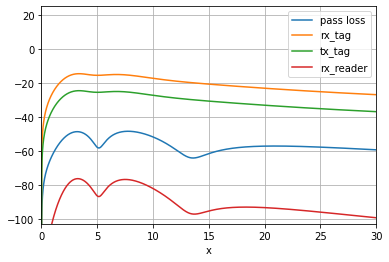

In [101]:
x = [x for x in np.arange(0.0001, 30, 0.01)]
rx_list_tag = [snr_to_ber.get_reader_power(x) for x in x]
rx_list_reader = [snr_to_ber.get_tag_power(x)-10 for x in x]
rx_power_list = [snr_to_ber.sum_of_rx_power(x) for x in x]
path_loss_reader = [snr_to_ber.lin2db(snr_to_ber.get_path_loth_for_reader(x)) for x in x]
path_loss_tag = [snr_to_ber.lin2db(snr_to_ber.get_path_loth_for_tag(x)) for x in x]
tx_tag = [snr_to_ber.get_reader_power(x)-10 for x in x]

df = pd.DataFrame()
df['x'] = x
df['pass loss'] = path_loss_tag
df['rx_tag'] = rx_list_tag
df['tx_tag'] = tx_tag
df['rx_reader'] = rx_list_reader
#df['rx_power'] = rx_power_list
#df['pass loss reader'] = path_loss_reader
#df['pass loss tag'] = path_loss_tag
df.plot(x='x', xlim=(0,30), ylim=(-103, 25), grid=True)

In [102]:
name_col = ['FM0', 'M2', 'M4', 'M8']
num_of_sym_per_bit_list = [1, 2, 4, 8]
x = [x for x in np.arange(0.0001, L, 0.01)]

ber_df = pd.DataFrame()
ber_df['x'] = x
rx_list = [snr_to_ber.get_tag_power(x) for x in x]

def get_plot_ber(tari):
    i = 0
    variables_by_tari = variables.get_variables_from_tari(tari)
    for m in num_of_sym_per_bit_list:
        bitrate = variables.get_bitrate(variables_by_tari.rtcal,
                                    variables_by_tari.blf,
                                    m)
        preamble = variables.get_preamble(tari, variables_by_tari.rtcal,
                                        variables_by_tari.trcal,
                                        trext, m)
        snr_list = [snr_to_ber.get_snr(rx_power=rx ,m=m,
                                        preamble_duration=preamble.tag_preamble_len/bitrate.tag_bitrate,
                                        blf=variables_by_tari.blf) for rx in rx_list]

                                    
        ber = [snr_to_ber.ber_over_rayleigh(snr) for snr in snr_list]
        #ber = [snr_to_ber.ber_over_awgn(snr) for snr in snr_list]
        ber_df[name_col[i]] = ber
        i+=1
    ber_df.plot(x='x', ylim=(0,0.12), xlabel='d, m', ylabel='BER', grid=True)

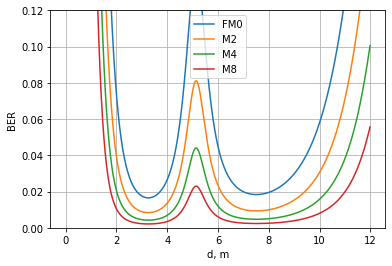

In [83]:
get_plot_ber(tari)

In [103]:
def ber_func_from_x(x):
    variables_by_tari = variables.get_variables_from_tari(tari)
    bitrate = variables.get_bitrate(variables_by_tari.rtcal,
                                    variables_by_tari.blf,
                                    m)
    preamble = variables.get_preamble(tari, variables_by_tari.rtcal,
                                        variables_by_tari.trcal,
                                        trext, m)
    rx = snr_to_ber.get_tag_power(x)
    snr = snr_to_ber.get_snr(rx_power=rx,m=m,
                                preamble_duration=preamble.tag_preamble_len/bitrate.tag_bitrate,
                                blf=variables_by_tari.blf)
    if snr_to_ber.ber_over_rayleigh(snr) > MAX_BER:
        return MAX_BER
    return snr_to_ber.ber_over_rayleigh(snr)

In [104]:
def build_B(a1, a2, b1, b2, x1, x2, x):
    a = b1 - b2
    b = -2*(b1*x1 - b2*x2)
    c = a1 - a2 + b1*(x1**2) - b2*(x2**2)
    D = b**2 - 4*a*c
    L0 = (-b + D**0.5) / (2 * a)
    first_paralabola = a1 + b1 * (x - x1)**2
    second_parabola = a2 + b2 * (x - x2)**2
    if x < L0:
        if first_paralabola > MAX_BER:
            return MAX_BER
        return a1 + b1 * (x - x1)**2
    if second_parabola > MAX_BER:
        return MAX_BER
    return a2 + b2 * (x - x2)**2

def integ(x_opt):
    #a1, a2, b1, b2, x1, x2
    #0-a1, 1-a2, 2-b1, 3-b2, 4-x1, 5-x2
    def fn(x):
        a1 = build_B(x_opt[0], x_opt[1], x_opt[2], x_opt[3], x_opt[4], x_opt[5], x)
        a2 = ber_func_from_x(x)
        return (a1 - a2) ** 2
    return quad(fn, 0, L)[0]

In [105]:
bnds = ((0, 0.1), (0, 0.1), (0, 1), (0, 1), (0, 12), (0, 12))
x_opt_0 = (0.0361709, 0.01968352, 0.04023841, 0.01624674, 3.8756385, 7.81955679)
res_bfgs = minimize(integ, x_opt_0, method='BFGS', bounds=bnds, options={'xtol': 1e-5, 'disp': True})

/Users/fenik/Documents/rfid_project/.venv/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
<ipython-input-105-95b4e9602640>:3: OptimizeWarning: Unknown solver options: xtol
  res_bfgs = minimize(integ, x_opt_0, method='BFGS', bounds=bnds, options={'xtol': 1e-5, 'disp': True})
<ipython-input-104-ae521b471344>:6: RuntimeWarning: invalid value encountered in double_scalars
  L0 = (-b + D**0.5) / (2 * a)
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 39
         Function evaluations: 329
         Gradient evaluations: 47


In [106]:
res_bfgs

      fun: 1.9542087617312935e-05
 hess_inv: array([[ 3.87681992e-01, -7.89474292e-03, -4.66338548e-01,
         2.39787693e-03, -3.20121299e-01,  1.57666035e-01],
       [-7.89474292e-03,  2.30980641e-01,  2.07572939e-02,
        -9.31117026e-02, -2.74881266e-01,  5.59405099e-01],
       [-4.66338548e-01,  2.07572939e-02,  1.06533490e+00,
        -1.09603454e-02,  6.20450169e-01,  2.84401571e-01],
       [ 2.39787693e-03, -9.31117026e-02, -1.09603454e-02,
         6.47845498e-02,  1.29322130e-01, -5.07133203e-01],
       [-3.20121299e-01, -2.74881266e-01,  6.20450169e-01,
         1.29322130e-01,  1.78689859e+02, -4.28010356e+00],
       [ 1.57666035e-01,  5.59405099e-01,  2.84401571e-01,
        -5.07133203e-01, -4.28010356e+00,  3.92505256e+02]])
      jac: array([-1.05750860e-06, -5.92629021e-07, -8.75566229e-07, -8.28914608e-07,
        2.72925718e-08, -8.67441940e-08])
  message: 'Optimization terminated successfully.'
     nfev: 329
      nit: 39
     njev: 47
   status: 0
  suc

/Users/fenik/Documents/rfid_project/model/model/snr_to_ber.py:191: RuntimeWarning: divide by zero encountered in lin2db
  tag_power = get_rx_power(x=x, path_loss=lin2db(get_path_loth_for_tag(x)), tx_power=get_reader_power(x), cable_loss=0, tag_modulation_loss=-10.0)
/Users/fenik/Documents/rfid_project/model/model/snr_to_ber.py:187: RuntimeWarning: divide by zero encountered in lin2db
  reader_power = get_rx_power(x=x, path_loss=lin2db(get_path_loth_for_reader(x)), tx_power=reader_tx_power, cable_loss=-2.0, tag_modulation_loss=0)
/Users/fenik/Documents/rfid_project/model/model/snr_to_ber.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  return (snr * preamble_duration * bandwidth) ** -0.5
/Users/fenik/Documents/rfid_project/model/model/snr_to_ber.py:232: RuntimeWarning: invalid value encountered in cos
  return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 2


<AxesSubplot:xlabel='d, m', ylabel='BER'>

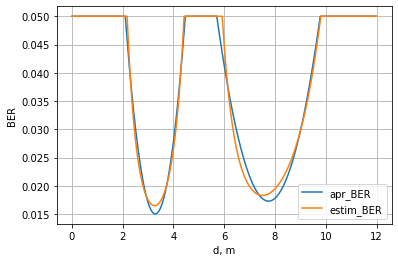

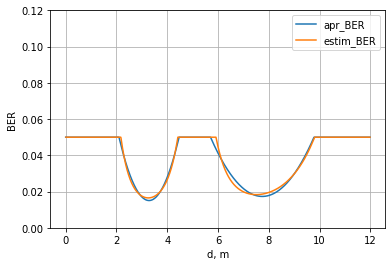

In [107]:
compare_df = pd.DataFrame()
compare_df['d, m'] = [x for x in np.arange(0, L, 0.01)]
compare_df['apr_BER'] = [build_B(res_bfgs.x[0], res_bfgs.x[1], res_bfgs.x[2], res_bfgs.x[3], res_bfgs.x[4], res_bfgs.x[5], d) for d in np.arange(0,L, 0.01)]
compare_df['estim_BER'] = [ber_func_from_x(x) for x in np.arange(0, L, 0.01)]

compare_df.plot(x='d, m', ylabel='BER', grid=True)
compare_df.plot(x='d, m', ylabel='BER', ylim=(0,0.12), grid=True)

In [111]:
def num_int(Q, Q1, Q2, V, dt, T, L, B):
    def fn(x):
        k1 = np.exp(-B(x) * Q)
        k2 = Q2 * dt * np.exp(-B(x) * Q1) 
        if k2 <= (T0 + T1 + T3):
            k2 = (T0 + T1 + T3)
        return k1 / (V*k2)
    t = quad(fn, V*T, L)[0] 
    

    return 1 - np.exp(-t)

def build_B_new(a1, a2, b1, b2, x1, x2):
    def fn(x):
        a = b1 - b2
        b = -2*(b1*x1 - b2*x2)
        c = a1 - a2 + b1*(x1**2) - b2*(x2**2)
        D = b**2 - 4*a*c
        L0 = (-b + D**0.5) / (2 * a)
        if x < L0:
            return a1 + b1 * (x - x1)**2
        return a2 + b2 * (x - x2)**2
    return fn

B = build_B_new(
    a1=res_bfgs.x[0],
    a2=res_bfgs.x[1],
    b1=res_bfgs.x[2],
    b2=res_bfgs.x[3],
    #L0=6.0,
    x1=res_bfgs.x[4],
    x2=res_bfgs.x[5]
)

<AxesSubplot:title={'center':'Probability'}, xlabel='v, m/s', ylabel='p'>

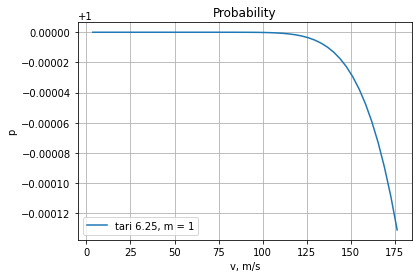

In [112]:
plot_theor = pd.DataFrame()
plot_theor['v, m/s'] = [v*3.6 for v in range(1, 50)]
plot_theor['tari 6.25, m = 1'] = [num_int(Q1=8.27860441, Q2=105.4439353, Q=16+128, V=v, T=(N0+N2)*tari*1e-6, dt=tari*1e-6, L=L, B=B) for v in range(1, 50)]
plot_theor.plot(x='v, m/s', ylabel='p', grid=True, title='Probability')

In [113]:
num_int(Q1=8.27860441, Q2=105.4439353, Q=16+128, V=50, T=(N0+N2)*tari*1e-6, dt=tari*1e-6, L=L, B=B)

0.9998432750195932

In [219]:
m

1